In [1]:
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
from torchvision import datasets, transforms



Torch: 2.6.0+cpu
Torchvision: 0.21.0+cpu


In [2]:
import os
import time
import copy
import csv
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [3]:
#Hyperparameters
OUT_DIR = Path("outputs_resnet_vs_baseline")
OUT_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

BATCH_SIZE = 128
NUM_EPOCHS = 50
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
STEP_LR_MILESTONES = [30, 40]
LR_GAMMA = 0.1

INPUT_CHANNELS = 3
NUM_CLASSES = 10
IMG_SIZE = 32


In [4]:
# Data transforms and loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


In [5]:
# split and  train 
val_size = 5000
train_size = len(trainset) - val_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
# CNN 
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [7]:
#Simple ResNet block (basic block like ResNet-18/34)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # layers
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out

def ResNet18_CIFAR():
    # Keep it small for CIFAR: blocks [2,2,2]
    return SimpleResNet(BasicBlock, [2,2,2], num_classes=NUM_CLASSES)

In [8]:
#train test
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, 100.0 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100.0 * correct / total

In [9]:
# Train both models
# ---------------------------
def run_experiment(model, model_name, num_epochs=NUM_EPOCHS):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=STEP_LR_MILESTONES, gamma=LR_GAMMA)
    history = {"epoch":[],"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
        scheduler.step()
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), OUT_DIR / f"{model_name}_best.pth")

        print(f"[{model_name}] Epoch {epoch}/{num_epochs}: train_acc={train_acc:.2f} val_acc={val_acc:.2f} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

    elapsed = time.time() - start_time
    print(f"Finished training {model_name} in {elapsed/60:.2f} min. Best val acc: {best_val_acc:.2f}")
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), OUT_DIR / f"{model_name}_final.pth")

    # test
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    print(f"[{model_name}] Test acc: {test_acc:.2f} test_loss: {test_loss:.4f}")

    # save history CSV
    csv_path = OUT_DIR / f"{model_name}_history.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(history.keys())
        writer.writerows(zip(*history.values()))

    return history, test_acc


In [10]:
#model run kr wa raha hu 
baseline = BaselineCNN(num_classes=NUM_CLASSES)
resnet = ResNet18_CIFAR()

hist_baseline, test_acc_baseline = run_experiment(baseline, "baseline_cnn")
hist_resnet, test_acc_resnet = run_experiment(resnet, "resnet_cifar")

[baseline_cnn] Epoch 1/50: train_acc=48.69 val_acc=59.98 train_loss=1.4067 val_loss=1.1404
[baseline_cnn] Epoch 2/50: train_acc=65.00 val_acc=66.48 train_loss=0.9826 val_loss=0.9346
[baseline_cnn] Epoch 3/50: train_acc=71.65 val_acc=70.22 train_loss=0.8058 val_loss=0.8397
[baseline_cnn] Epoch 4/50: train_acc=75.64 val_acc=72.12 train_loss=0.6977 val_loss=0.7765
[baseline_cnn] Epoch 5/50: train_acc=78.33 val_acc=73.84 train_loss=0.6256 val_loss=0.7473
[baseline_cnn] Epoch 6/50: train_acc=80.30 val_acc=74.24 train_loss=0.5709 val_loss=0.7751
[baseline_cnn] Epoch 7/50: train_acc=81.89 val_acc=72.30 train_loss=0.5233 val_loss=0.8112
[baseline_cnn] Epoch 8/50: train_acc=83.14 val_acc=76.58 train_loss=0.4898 val_loss=0.6819
[baseline_cnn] Epoch 9/50: train_acc=84.26 val_acc=81.02 train_loss=0.4604 val_loss=0.5296
[baseline_cnn] Epoch 10/50: train_acc=84.91 val_acc=80.24 train_loss=0.4375 val_loss=0.5835
[baseline_cnn] Epoch 11/50: train_acc=85.77 val_acc=80.48 train_loss=0.4121 val_loss=0.57

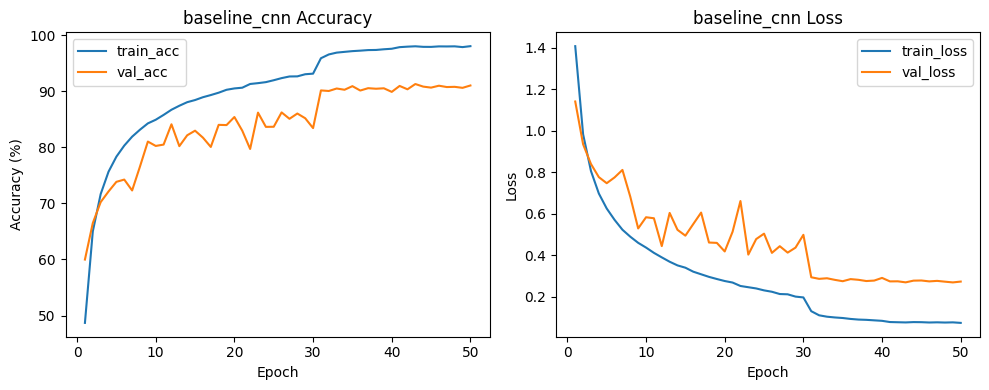

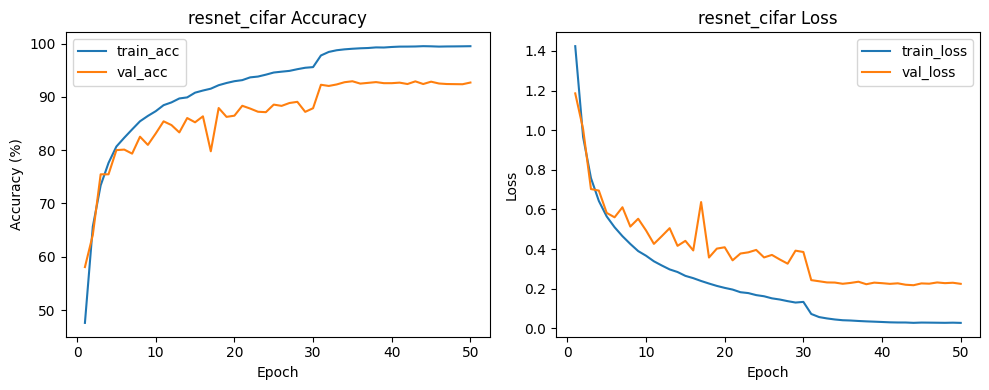

All outputs saved to C:\Users\jayen\rasnet vs cnn\outputs_resnet_vs_baseline


In [11]:
def plot_history(hist, model_name):
    epochs = hist["epoch"]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist["train_acc"], label="train_acc")
    plt.plot(epochs, hist["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.subplot(1,2,2)
    plt.plot(epochs, hist["train_loss"], label="train_loss")
    plt.plot(epochs, hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{model_name}_training_plot.png")
    plt.show()

plot_history(hist_baseline, "baseline_cnn")
plot_history(hist_resnet, "resnet_cifar")

print("All outputs saved to", OUT_DIR.resolve())

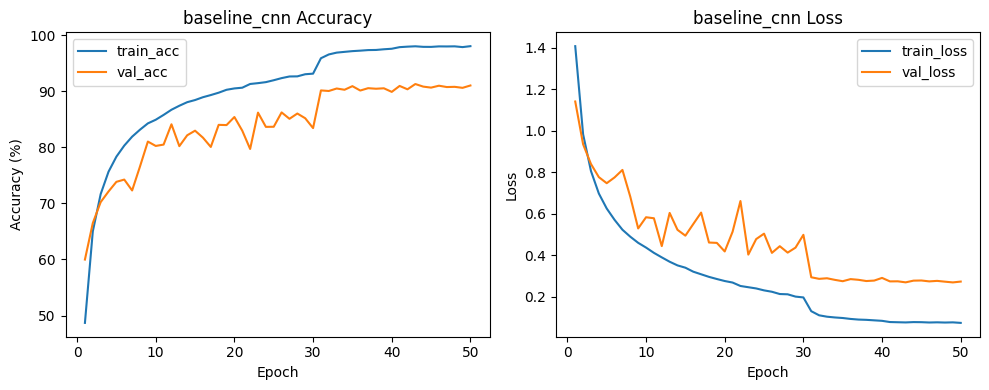

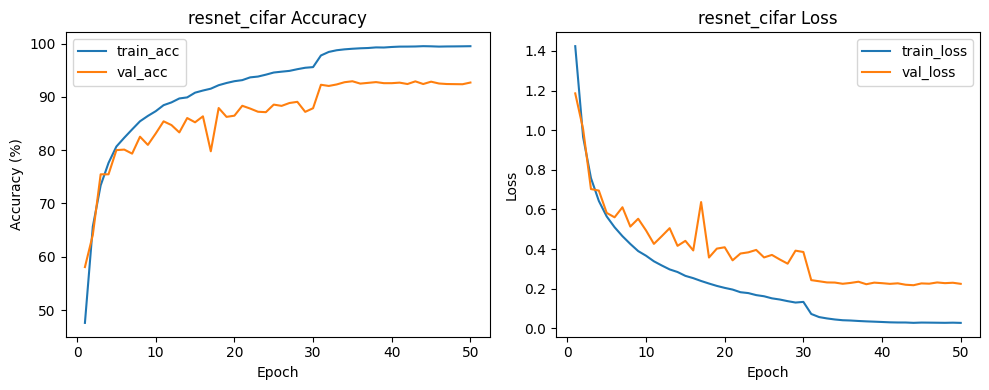

In [14]:
plot_history(hist_baseline,"baseline_cnn")
plot_history(hist_resnet,"resnet_cifar")


In [16]:
import pandas as pd
pd.DataFrame(hist_baseline).to_csv("baseline_results.csv", index=False)
pd.DataFrame(hist_resnet).to_csv("resnet_results.csv", index=False)